# Question-Answering System Performance Summary

Key performance metrics and results from our QA system evaluation.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Style
sns.set_theme(style="whitegrid")
sns.set_palette("Set2")
plt.rcParams["figure.figsize"] = (12, 6)

# Load evaluation data
DF_PATH = "C:\\baykar_project\\data\\evaluate\\combined_evaluation_metrics.csv"
df = pd.read_csv(DF_PATH)

# Remove rows where the model said it didn't have enough information
if "generated_answer" in df.columns:
    mask = df["generated_answer"].str.contains("I do not have sufficient information", case=False, na=False)
    if mask.any():
        df = df[~mask].reset_index(drop=True)

# Basic preprocessing for plots only
text_cols = ["generated_answer", "expected_answer", "query"]
for c in text_cols:
    if c in df.columns:
        df[c] = df[c].astype(str)

# Flags / helper columns
if "generated_answer" in df.columns:
    df["dont_know"] = df["generated_answer"].str.contains("I do not have sufficient information", case=False, na=False)
    df["answer_len_chars"] = df["generated_answer"].str.len()
    df["answer_len_words"] = df["generated_answer"].str.split().apply(len)

# Coerce numeric columns if needed (ignore errors)
num_candidates = [
    # Quality
    "Accuracy","Relevance","Fluency",
    # Auto metrics
    "BLEU","ROUGE-1","ROUGE-2","ROUGE-L","METEOR",
    "BERTScore-P","BERTScore-R","BERTScore-F1","Perplexity",
    # Timing
    "Total_Time_MS","Retrieval_Time_MS","Generation_Time_MS",
    # Other helpful
    "Query_Length"
]
for col in num_candidates:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.head()

,query,expected_answer,generated_answer,Relevance,Accuracy,Source_Citation,Fluency,Query_Length,Retrieval_Time_MS,Generation_Time_MS,...,ROUGE-2,ROUGE-L,METEOR,BERTScore-P,BERTScore-R,BERTScore-F1,Perplexity,dont_know,answer_len_chars,answer_len_words
0,"A decade after delivery, which hypertension ph...",Hypertensive disorders in pregnancy were assoc...,The study found that nearly 40% of women who e...,4,2,Yes,5,118,13.0162,3293.7527,...,0.103896,0.151899,0.281286,0.732335,0.765079,0.748349,44.309135,False,403,52
1,Did the Hindi Mini-mental Status Examination (...,"No, the HMSE, Hindi MoCA, and choice reaction ...",The Hindi Mini-mental Status Examination (HMSE...,5,2,Yes,5,172,11.6736,2513.4440,...,0.000000,0.244898,0.231091,0.686391,0.771544,0.726481,46.856411,False,194,24
2,How did ACE inhibitor treatment affect vasodil...,ACE inhibitor treatment improved the vasodilat...,ACE inhibitor treatment improved vasodilatatio...,5,5,Yes,5,82,12.5403,2248.8133,...,0.357143,0.533333,0.727154,0.740021,0.928649,0.823674,50.008240,False,131,16
3,How did LV and RV mass compare between African...,Left ventricular (LV) and right ventricular (R...,RV mass and M/V were significantly greater in ...,3,2,Yes,5,124,10.8657,2530.9250,...,0.157895,0.333333,0.330424,0.763949,0.672671,0.715410,60.305107,False,182,25
4,How did atorvastatin calcium and AG490 affect ...,Both the HMG-CoA reductase inhibitor (atorvast...,Atorvastatin calcium and AG490 decreased the e...,5,5,Yes,5,117,13.6012,2808.8287,...,0.416667,0.480000,0.456077,0.794988,0.853996,0.823436,18.794329,False,146,17


In [21]:
# Metrics summary table
# Compute descriptive statistics and missing data counts for key numeric metrics
metrics = [
    "Accuracy","Relevance","Fluency",
    "BLEU","ROUGE-1","ROUGE-2","ROUGE-L","METEOR",
    "BERTScore-P","BERTScore-R","BERTScore-F1","Perplexity",
    "Total_Time_MS","Retrieval_Time_MS","Generation_Time_MS",
    "Query_Length","answer_len_words","answer_len_chars"
]

present = [c for c in metrics if c in df.columns]

summary = df[present].describe().T
summary['missing'] = df[present].isna().sum().values
summary['median'] = df[present].median().values
# reorder
summary = summary[['count','missing','mean','median','std','min','25%','50%','75%','max']]

# Display
summary.style.format({col: "{:.3f}" for col in ['mean','median','std','min','25%','50%','75%','max']})

,count,missing,mean,median,std,min,25%,50%,75%,max
Accuracy,53.000000,0,3.811,4.000,1.345,1.000,2.000,4.000,5.000,5.000
Relevance,53.000000,0,4.491,5.000,0.775,2.000,4.000,5.000,5.000,5.000
Fluency,53.000000,0,5.000,5.000,0.000,5.000,5.000,5.000,5.000,5.000
BLEU,53.000000,0,0.135,0.076,0.177,0.000,0.000,0.076,0.243,0.712
ROUGE-1,53.000000,0,0.436,0.400,0.184,0.098,0.294,0.400,0.578,0.885
ROUGE-2,53.000000,0,0.258,0.195,0.197,0.000,0.107,0.195,0.390,0.840
ROUGE-L,53.000000,0,0.358,0.302,0.188,0.078,0.235,0.302,0.480,0.885
METEOR,53.000000,0,0.438,0.415,0.208,0.118,0.278,0.415,0.586,0.882
BERTScore-P,53.000000,0,0.731,0.730,0.064,0.580,0.681,0.730,0.776,0.858
BERTScore-R,53.000000,0,0.822,0.845,0.093,0.550,0.763,0.845,0.895,0.974


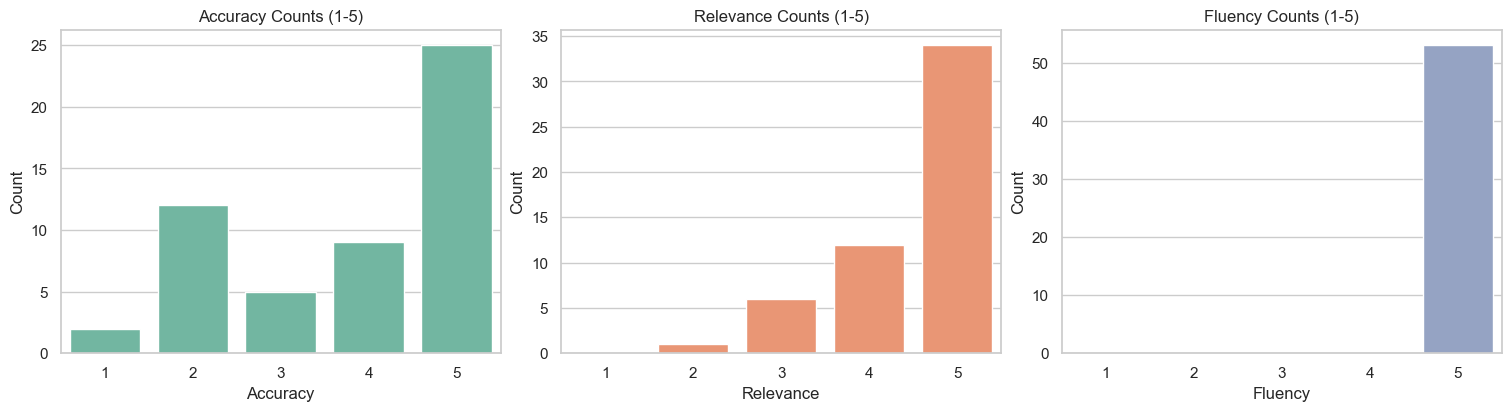

In [22]:
# Quality metrics: Accuracy, Relevance, Fluency (discrete 1-5 counts)
quality_cols = [c for c in ["Accuracy", "Relevance", "Fluency"] if c in df.columns]

if quality_cols:
    fig, axes = plt.subplots(1, len(quality_cols), figsize=(5*len(quality_cols), 4), constrained_layout=True)
    if len(quality_cols) == 1:
        axes = [axes]
    for i, col in enumerate(quality_cols):
        # Coerce to numeric, round to nearest integer, clip to 1..5
        series = pd.to_numeric(df[col], errors='coerce').round().clip(1,5).dropna().astype(int)
        order = [1,2,3,4,5]
        sns.countplot(x=series, order=order, ax=axes[i], palette=[sns.color_palette()[i % len(sns.color_palette())]])
        axes[i].set_title(f"{col} Counts (1-5)")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
    plt.show()
else:
    print("No quality metric columns found.")

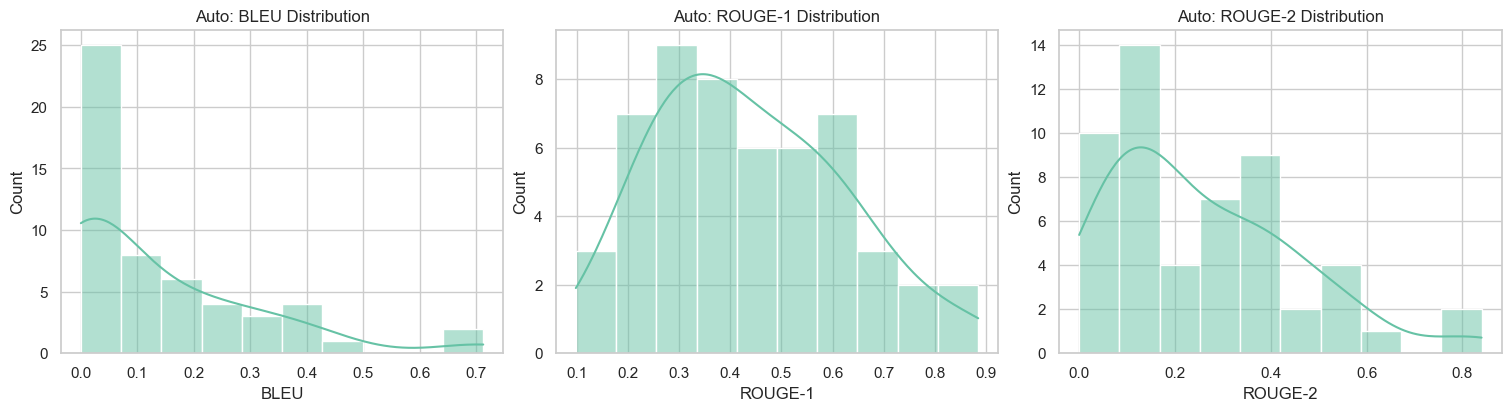

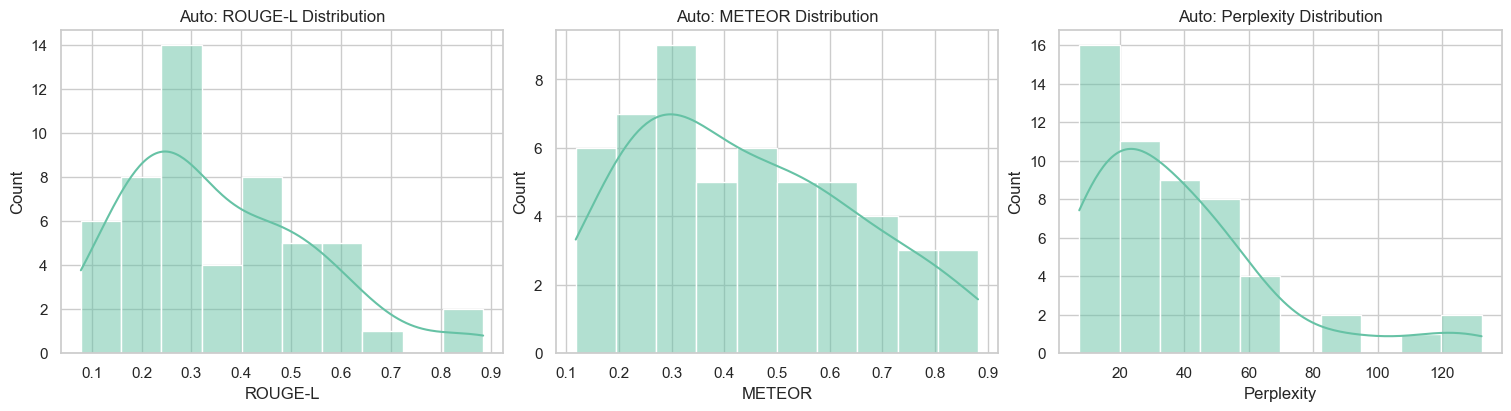

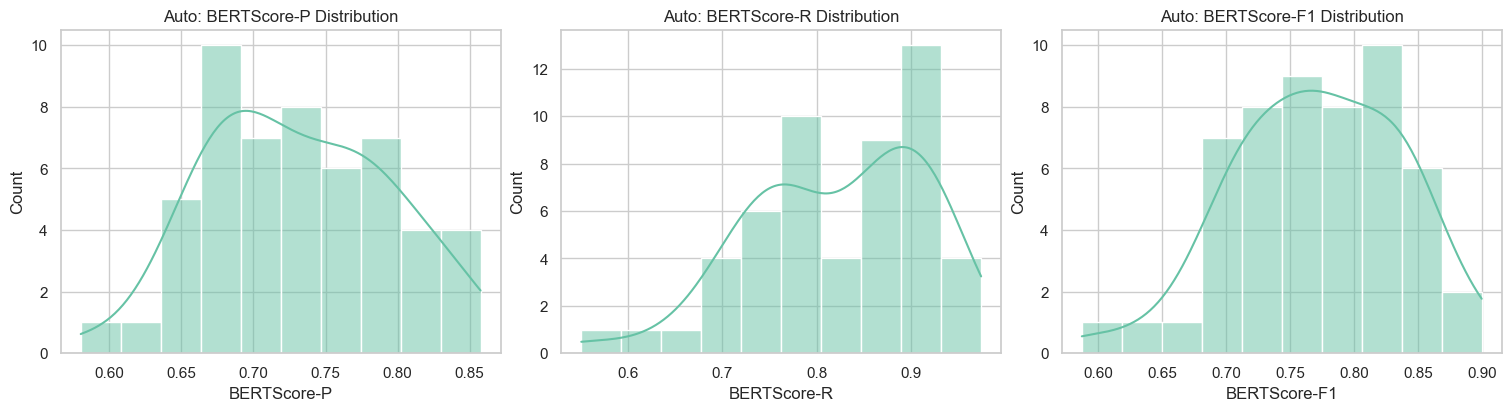

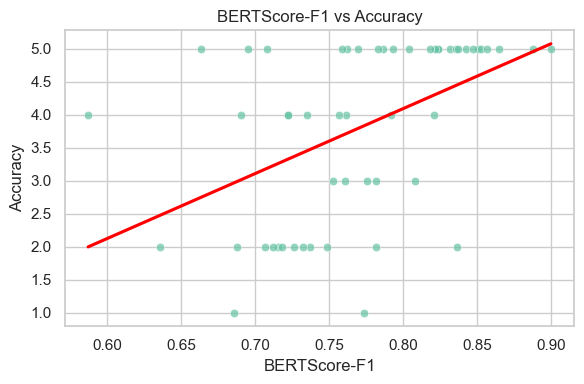

In [23]:
# Automated metrics: Include all available automatic metrics from CSV and split into 3 groups
all_auto_candidates = [
    "BLEU","ROUGE-1","ROUGE-2","ROUGE-L","METEOR",
    "BERTScore-P","BERTScore-R","BERTScore-F1","Perplexity"
]
auto_cols = [c for c in all_auto_candidates if c in df.columns]

# Helper to plot a list of cols in a single row of subplots
def plot_group(cols, title_prefix=""):
    if not cols:
        return
    fig, axes = plt.subplots(1, len(cols), figsize=(5*len(cols), 4), constrained_layout=True)
    if len(cols) == 1:
        axes = [axes]
    for i, col in enumerate(cols):
        sns.histplot(df[col].dropna(), bins=10, kde=True, ax=axes[i])
        axes[i].set_title(f"{title_prefix}{col} Distribution")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
    plt.show()

if auto_cols:
    # Split into roughly 3 groups
    group1 = [c for c in ["BLEU","ROUGE-1","ROUGE-2"] if c in auto_cols]
    group2 = [c for c in ["ROUGE-L","METEOR","Perplexity"] if c in auto_cols]
    group3 = [c for c in ["BERTScore-P","BERTScore-R","BERTScore-F1"] if c in auto_cols]

    plot_group(group1, title_prefix="Auto: ")
    plot_group(group2, title_prefix="Auto: ")
    plot_group(group3, title_prefix="Auto: ")

    # Keep only BERTScore-F1 vs Accuracy scatter
    if "Accuracy" in df.columns and "BERTScore-F1" in df.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df["BERTScore-F1"], y=df["Accuracy"], alpha=0.7)
        sns.regplot(x=df["BERTScore-F1"], y=df["Accuracy"], scatter=False, ci=None, color='red')
        plt.xlabel("BERTScore-F1")
        plt.ylabel("Accuracy")
        plt.title("BERTScore-F1 vs Accuracy")
        plt.tight_layout()
        plt.show()
else:
    print("No automated metric columns found.")

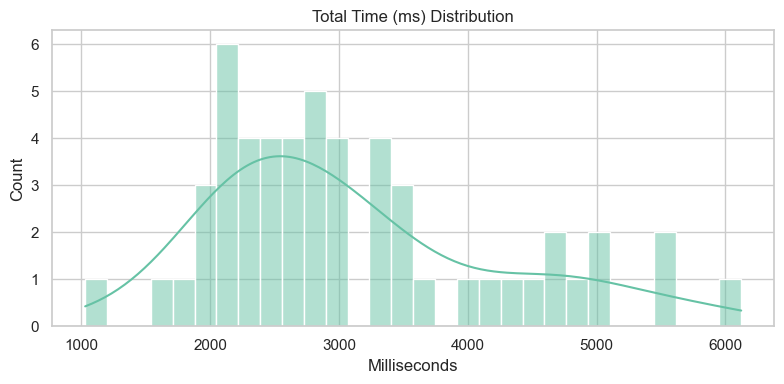

In [24]:
# Timing visualization: Keep only Total time distribution
if "Total_Time_MS" in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df["Total_Time_MS"].dropna(), bins=30, kde=True)
    plt.title("Total Time (ms) Distribution")
    plt.xlabel("Milliseconds")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Total_Time_MS column not found.")

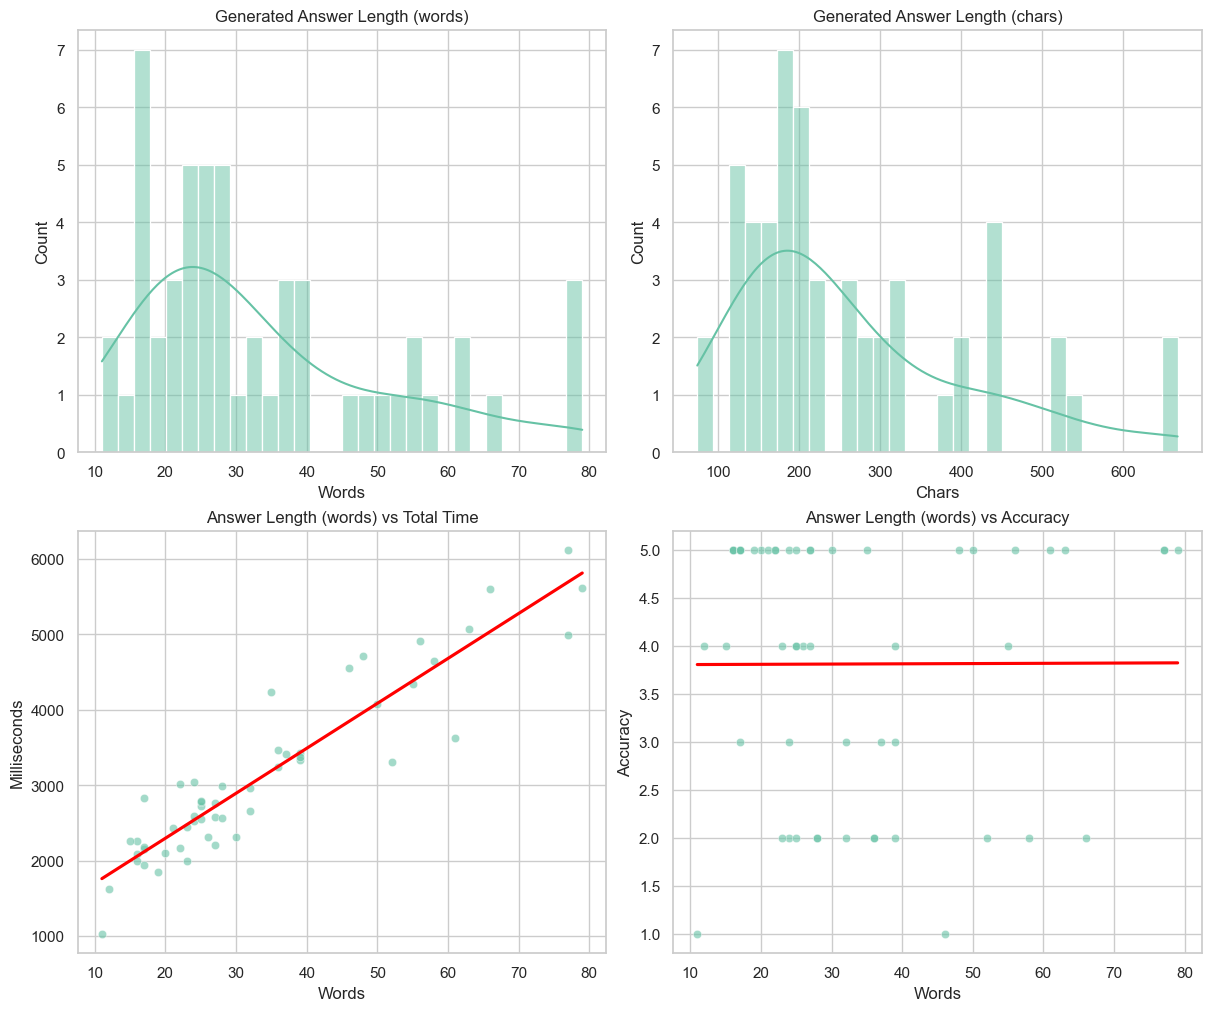

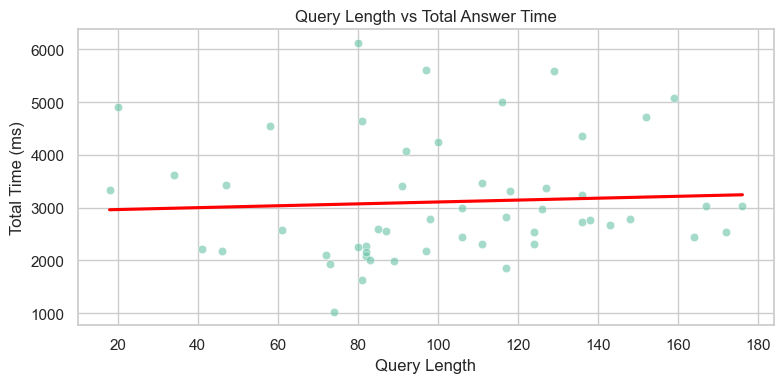

In [25]:
# Answer length visualizations and relationships
if "answer_len_words" in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

    # Length distributions
    sns.histplot(df["answer_len_words"].dropna(), bins=30, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title("Generated Answer Length (words)")
    axes[0, 0].set_xlabel("Words")

    sns.histplot(df["answer_len_chars"].dropna(), bins=30, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title("Generated Answer Length (chars)")
    axes[0, 1].set_xlabel("Chars")

    # Length vs total time
    if "Total_Time_MS" in df.columns:
        sns.scatterplot(x=df["answer_len_words"], y=df["Total_Time_MS"], alpha=0.6, ax=axes[1, 0])
        sns.regplot(x=df["answer_len_words"], y=df["Total_Time_MS"], scatter=False, ci=None, color='red', ax=axes[1, 0])
        axes[1, 0].set_title("Answer Length (words) vs Total Time")
        axes[1, 0].set_xlabel("Words")
        axes[1, 0].set_ylabel("Milliseconds")

    # Length vs accuracy
    if "Accuracy" in df.columns:
        sns.scatterplot(x=df["answer_len_words"], y=df["Accuracy"], alpha=0.6, ax=axes[1, 1])
        sns.regplot(x=df["answer_len_words"], y=df["Accuracy"], scatter=False, ci=None, color='red', ax=axes[1, 1])
        axes[1, 1].set_title("Answer Length (words) vs Accuracy")
        axes[1, 1].set_xlabel("Words")
        axes[1, 1].set_ylabel("Accuracy")

    plt.show()

    # Query length vs answer (total) time
    if "Query_Length" in df.columns and "Total_Time_MS" in df.columns:
        plt.figure(figsize=(8,4))
        sns.scatterplot(x=df["Query_Length"].dropna(), y=df["Total_Time_MS"].dropna(), alpha=0.6)
        # Use regplot on aligned non-null pairs to avoid mismatch
        paired = df[["Query_Length","Total_Time_MS"]].dropna()
        sns.regplot(x=paired["Query_Length"], y=paired["Total_Time_MS"], scatter=False, ci=None, color='red')
        plt.title("Query Length vs Total Answer Time")
        plt.xlabel("Query Length")
        plt.ylabel("Total Time (ms)")
        plt.tight_layout()
        plt.show()
else:
    print("No answer length columns found.")

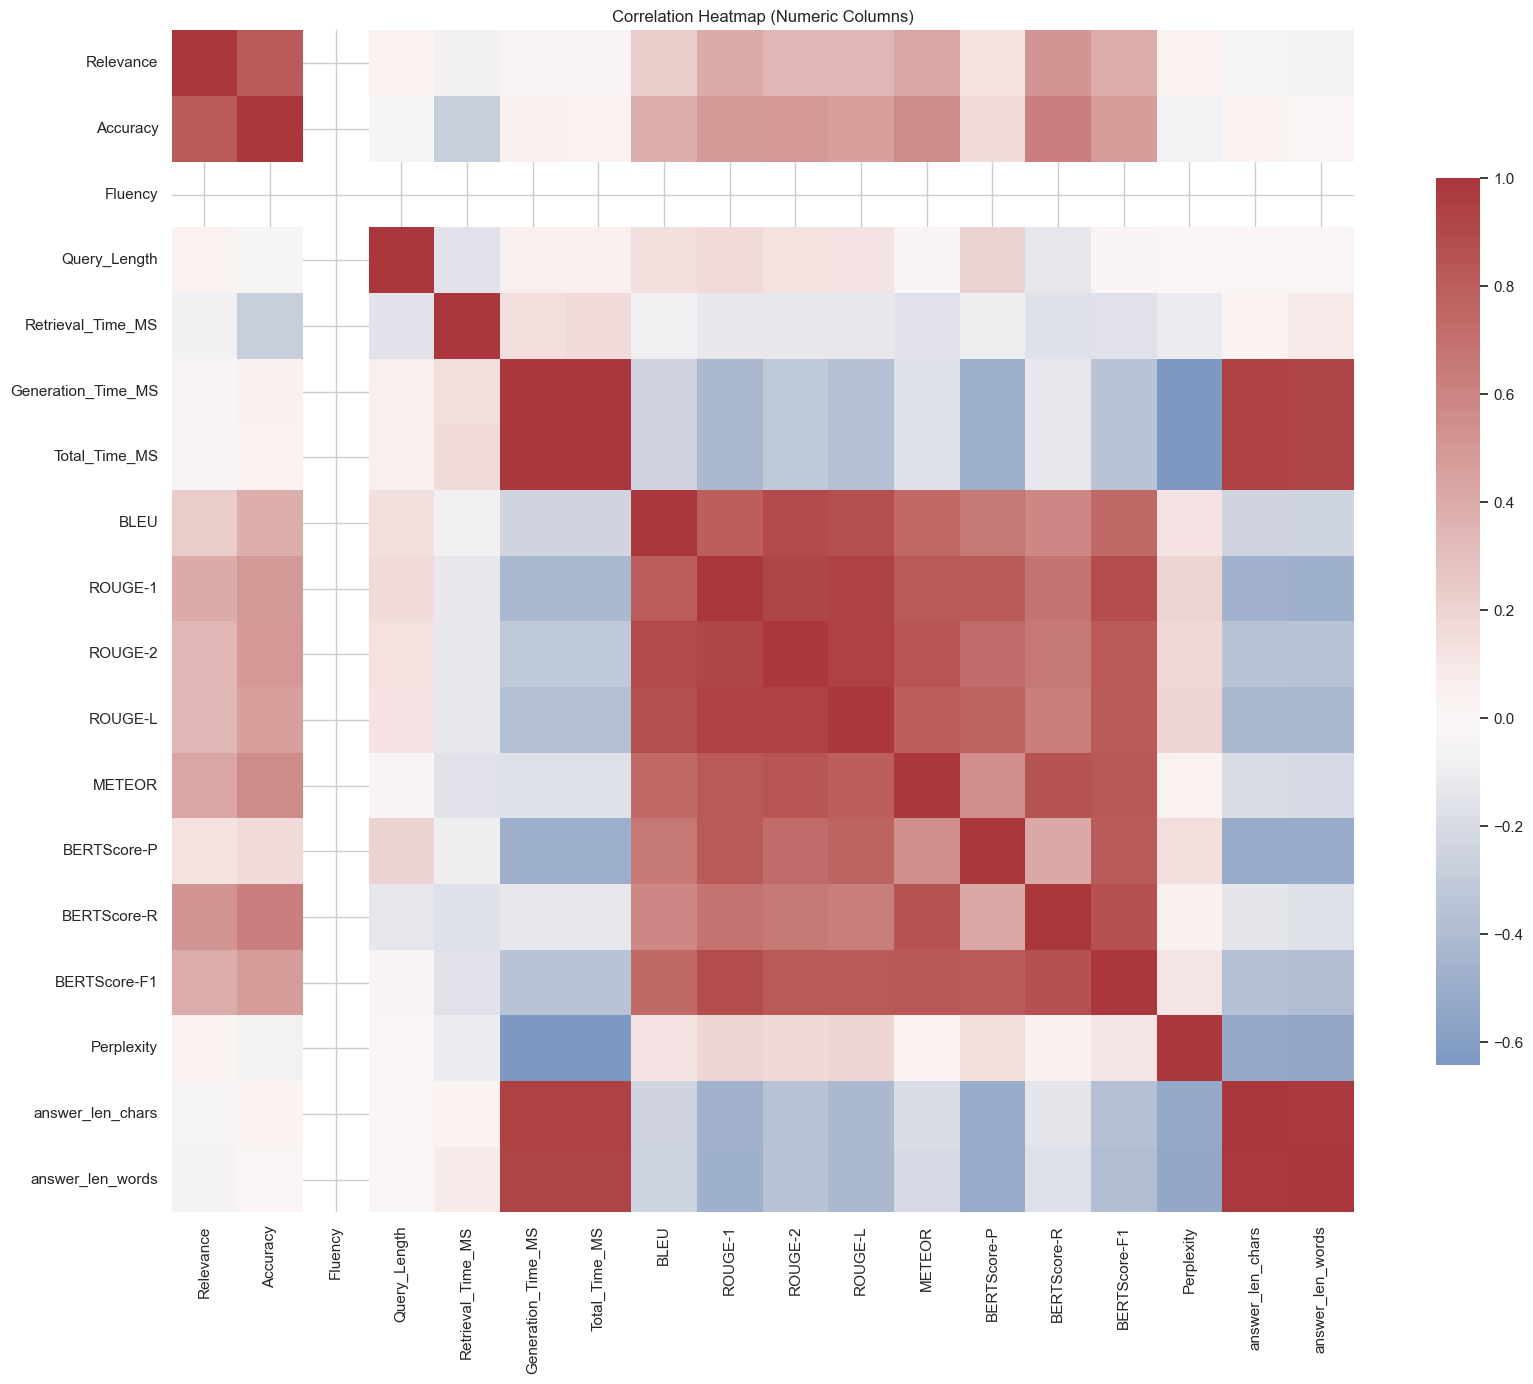

In [26]:
# Correlation heatmap among numeric metrics
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if num_cols:
    corr = df[num_cols].corr()
    plt.figure(figsize=(min(18, 1.2*len(num_cols)), min(14, 0.8*len(num_cols))) )
    sns.heatmap(corr, annot=False, cmap="vlag", center=0, square=True, cbar_kws={"shrink": .75})
    plt.title("Correlation Heatmap (Numeric Columns)")
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns for correlation heatmap.")